# Caching

Interacting with files on a cloud provider can mean a lot of waiting on files downloading and uploading. `cloudpathlib` provides seamless on-demand caching of cloud content that can be persistent across processes and sessions to make sure you only download or upload when you need to.

## Are we synced?

Before `cloudpathlib`, we spent a lot of time syncing our remote and local files. There was no great solution. For example, I just need one file, but I only have a script that downloads the entire 800GB bucket (or worse, you can't remember exactly _which_ files you need 🤮). Or _even worse_, you have all the files synced to your local machine, but you suspect that some are are up-to-date and some are stale. More often that I'd like to admit, the simplest answer was to blast the whole data directory and download all over again. Bandwidth doesn't grow on trees!


## Cache me if you can

Part of what makes `cloudpathlib` so useful is that it takes care of all of that, leaving your precious mental resources free to do other things! It maintains a local cache and only downloads a file if the local version and remote versions are out of sync. Every time you read or write a file, `cloudpathlib` goes through these steps:

- Does the file exist in the cache already?
- If no, download it to the cache.
- If yes, does the cached version have the same modtime as the cloud version?
- If it is older, re-download the file and replace the old cached version with the updated version from the cloud.
- If the local one is newer, something is up! We don't want to overwrite your local changes with the version from the cloud. If we see this scenario, we'll raise an error and offer some options to resolve the versions.

## Supporting reading and writing

The cache logic also support writing to cloud files seamlessly in addition to reading. We do this by tracking when a `CloudPath` is opened and on the close of that file, we will upload the new version to the cloud if it has changed.

**Warning** we don't upload files that weren't opened for write by `cloudpathlib`. For example, if you edit a file in the cache manually in a text edior, `cloudpathlib` won't know to update that file on the cloud. If you want to write to a file in the cloud, you should use the `open` or `write` methods, for example:

```python
with my_cloud_path.open("w") as f:
    f.write("My new text!")
```

This will download the file, write to the text to the local version in the cache, and when that file is closed we know to upload the changed version to the cloud.

As an example, let's look at using the [Low Altitude Disaster Imagery](https://registry.opendata.aws/ladi/) open dataset on S3. We'll view one images available of a flooding incident available on S3.

In [1]:
from cloudpathlib import CloudPath
from itertools import islice

ladi = CloudPath("s3://ladi/Images/FEMA_CAP/2020/70349")

# list first 5 images for this incident
for p in islice(ladi.iterdir(), 5):
    print(p)

s3://ladi/Images/FEMA_CAP/2020/70349/DSC_0001_5a63d42e-27c6-448a-84f1-bfc632125b8e.jpg
s3://ladi/Images/FEMA_CAP/2020/70349/DSC_0002_a89f1b79-786f-4dac-9dcc-609fb1a977b1.jpg
s3://ladi/Images/FEMA_CAP/2020/70349/DSC_0003_02c30af6-911e-4e01-8c24-7644da2b8672.jpg
s3://ladi/Images/FEMA_CAP/2020/70349/DSC_0004_d37c02b9-01a8-4672-b06f-2690d70e5e6b.jpg
s3://ladi/Images/FEMA_CAP/2020/70349/DSC_0005_d05609ce-1c45-4de3-b0f1-401c2bb3412c.jpg


Just because we saw these images are available, it doesn't mean we have downloaded any of this data yet.

In [2]:
# Nothing in the cache yet
!tree {ladi.fspath}

/var/folders/8g/v8lwvfhj6_l6ct_zd_rs84mw0000gn/T/tmpt_5xsme6/ladi/Images/FEMA_CAP/2020/70349 [error opening dir]

0 directories, 0 files


Now let's look at just the first image from this dataset.

In [3]:
flood_image = ladi / "DSC_0001_5a63d42e-27c6-448a-84f1-bfc632125b8e.jpg"
flood_image.exists()

True

In [4]:
# Still nothing in the cache
!tree {ladi.fspath}

/var/folders/8g/v8lwvfhj6_l6ct_zd_rs84mw0000gn/T/tmpt_5xsme6/ladi/Images/FEMA_CAP/2020/70349 [error opening dir]

0 directories, 0 files


Even though we refer to a specific file and make sure it exists in the cloud, we can still do all of that work without actually downloading the file.

In order to read the file, we do have to download the data. Let's actually display the image:

CPU times: user 1.31 s, sys: 275 ms, total: 1.59 s
Wall time: 1.92 s


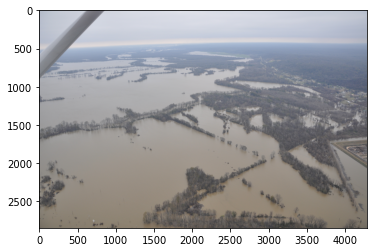

In [5]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

with flood_image.open("rb") as f:
    i = Image.open(f)
    plt.imshow(i)


In [6]:
# Downloaded image file in the cache
!tree {ladi.fspath}

/var/folders/8g/v8lwvfhj6_l6ct_zd_rs84mw0000gn/T/tmpt_5xsme6/ladi/Images/FEMA_CAP/2020/70349
└── DSC_0001_5a63d42e-27c6-448a-84f1-bfc632125b8e.jpg

0 directories, 1 file


Just be using `open`, we've downloaded the file in the background to the cache. Now that it is local, we won't redownload that file unless it changes on the server. We can confirm that by checking if the file is faster to read a second time.

CPU times: user 385 ms, sys: 39.7 ms, total: 424 ms
Wall time: 1.16 s


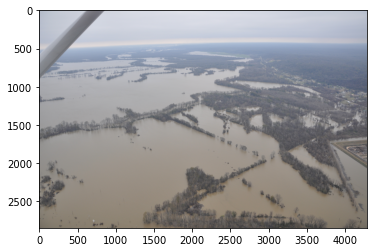

In [7]:
%%time
with flood_image.open("rb") as f:
    i = Image.open(f)
    plt.imshow(i)

Notice that the second display is much faster since we use the cached version!

## Keeping the cache around

By default, the cache uses [`tempfile`](https://docs.python.org/3/library/tempfile.html) this means at some point either Python or your operating system will remove whatever files you have cached. This is helpful in that it means the downloaded files get cleaned up regularly and don't necessarily clutter up your local hard drive.

However, sometimes I don't want to have to re-download files I know won't change. For example, in the LADI dataset, I may want to use the images in a Jupyter notebook and every time I restart the notebook I want to always have the downloaded files. I don't want to re-download since I know the LADI images won't be changing on S3.

We can do this just by using a `Client` that does all the downloading/uploading to a specfic folder on our local machine.

In [8]:
from cloudpathlib import S3Client

# cache to the folder 'data'
ladi = CloudPath(
    "s3://ladi/Images/FEMA_CAP/2020/70349",
    S3Client(local_cache_dir="data")
)

In [9]:
# Again, nothing in the cache yet, but we see it is all in the "data" folder
!tree {ladi.fspath}

data/ladi/Images/FEMA_CAP/2020/70349 [error opening dir]

0 directories, 0 files


Now let's look at just the first image from this dataset. Note that paths created by using the `ladi` root (e.g., by using the `/` operator below or calls like `iterdir` and `glob`) will inherit the same `Client` instance, and therefore the same `local_cache_dir` without our having to do extra work.

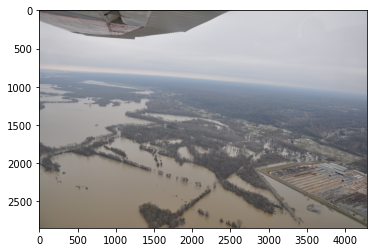

In [10]:
flood_image = ladi / "DSC_0002_a89f1b79-786f-4dac-9dcc-609fb1a977b1.jpg"

with flood_image.open("rb") as f:
    i = Image.open(f)
    plt.imshow(i)

In [11]:
# Now
!tree {ladi.fspath}

data/ladi/Images/FEMA_CAP/2020/70349
└── DSC_0002_a89f1b79-786f-4dac-9dcc-609fb1a977b1.jpg

0 directories, 1 file


In [12]:
# let's explicitly cleanup this directory, since it is not handled for us
!rm -rf data

## Accessing the cached version directly (read-only)

Many Python libraries don't properly handle `PathLike` objects. These libraries often only expect a `str` to be passed when working with files or, even worse, they will call `str(p)` on a Path that is passed before using it.

To use `cloudpathlib` with these libraries, you can pass `.fspath` which will provide the path to the cached version of the file as a string. 

**Warning:** Using the `.fspath` property will download the file from the cloud if it does not exist yet in the cache.

**Warning:** Since we are no longer in control of opening/closing the file, we cannot upload any changes when the file is closed. Therefore, you should treat any code where you use `fspath` as _read only_. Writes directly to `fspath` will not be uplaoded to the cloud.


## Handling conflicts

We try to be conservative in terms of not losing data—especially data stored on the cloud, which is likely to be the canonical version. Given this, we will raise exceptions in two scenarios:

`OverwriteNewerLocal`
This exception is raised if we are asked to download a file, but our local version in the cache is newer. This likely means that the cached version has been updated, but not pushed to the cloud. To work around this you could remove the cache version explicitly if you _know_ you don't need that data. If you did write changes you need, make sure your code uses the `cloudpathlib` versions of the `open`, `write_text`, or `write_bytes` methods, which will upload your changes to the cloud automatically.

The `CloudPath.open` method supports a `force_overwrite_from_cloud` kwarg to force overwriting your local version.

`OverwriteNewerCloud`
This exception is raised if we are asked to upload a file, but the one on the cloud is newer than our local version. This likely means that a separate process has updated the cloud version, and we don't want to overwrite and lose that new data in the cloud.

The `CloudPath.open` method supports a `force_overwrite_to_cloud` kwarg to force overwriting the cloud version.

